<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_06_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе 
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым 

Ссылка на архив: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

In [1]:
import gdown                                      # Подключим функцию gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)      # Скачивание файла

'20writers.zip'

In [2]:
# Распаковка архива в папку writers
!unzip -qo 20writers.zip -d writers/

# Просмотр содержимого папки
!ls writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [3]:
# Настройка констант для загрузки данных
FILE_DIR  = 'writers'                     # Папка с текстовыми файлами

In [4]:
# Работа с массивами данных
import numpy as np 

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [5]:
# Загрузка датасета. Добавляются имена классов и соответствующие тексты.
# Все тексты преобразуются в строку и объединяются для каждого класса и выборки
CLASS_LIST = []
text_data = []

for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса и типа выборки из имени файла
    m = re.match('([^\/]+)(?=\.\w+$)', file_name)
    # Если выделение получилось, то файл обрабатывается
    if m:
        class_name = m[1]
        # Добавление нового класса, если его еще нет в списке
        if class_name not in CLASS_LIST:
           print(f'Добавление класса "{class_name}"')
           CLASS_LIST.append(class_name)
           # Инициализация соответствующих классу строк текста
           text_data.append('')

           # Поиск индекса класса для добавления содержимого файла в выборку
           cls = CLASS_LIST.index(class_name)
           print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}".')
           with open(f'{FILE_DIR}/{file_name}', 'r') as f:
                # Загрузка содержимого файла в строку
                text = f.read()
           # Определение выборки, куда будет добавлено содержимое
           subset = text_data
           # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
           subset[cls] += ' ' + text.replace('\n', ' ')

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

Добавление класса "Васильев"
Добавление файла "Васильев.txt" в класс "Васильев".
Добавление класса "Пушкин"
Добавление файла "Пушкин.txt" в класс "Пушкин".
Добавление класса "Тургенев"
Добавление файла "Тургенев.txt" в класс "Тургенев".
Добавление класса "Грибоедов"
Добавление файла "Грибоедов.txt" в класс "Грибоедов".
Добавление класса "Достоевский"
Добавление файла "Достоевский.txt" в класс "Достоевский".
Добавление класса "Куприн"
Добавление файла "Куприн.txt" в класс "Куприн".
Добавление класса "Лермонтов"
Добавление файла "Лермонтов.txt" в класс "Лермонтов".
Добавление класса "Лесков"
Добавление файла "Лесков.txt" в класс "Лесков".
Добавление класса "Носов"
Добавление файла "Носов.txt" в класс "Носов".
Добавление класса "Катаев"
Добавление файла "Катаев.txt" в класс "Катаев".
Добавление класса "Горький"
Добавление файла "Горький.txt" в класс "Горький".
Добавление класса "Пастернак"
Добавление файла "Пастернак.txt" в класс "Пастернак".
Добавление класса "Каверин"
Добавление файла "

In [6]:
# Количество символов в каждом из текстов обучающей выборки
len_data = []
for i in range(CLASS_COUNT):
  len_data.append(len(text_data[i]))
  print(CLASS_LIST[i],' = ', len(text_data[i]))

Васильев  =  2952793
Пушкин  =  3408340
Тургенев  =  1980207
Грибоедов  =  969110
Достоевский  =  5178951
Куприн  =  2328901
Лермонтов  =  1972542
Лесков  =  2152215
Носов  =  2399414
Катаев  =  2579247
Горький  =  2523381
Пастернак  =  3089427
Каверин  =  1992831
Чехов  =  6611628
Шолохов  =  3386269
Булгаков  =  2001065
Гончаров  =  3104713
Беляев  =  2255255
Толстой  =  3357062
Гоголь  =  1965120


In [7]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
for cls in range(CLASS_COUNT):
    print(f'Класс: {CLASS_LIST[cls]}')
    print(f'  train: {text_data[cls][:100]}')
    print()

Класс: Васильев
  train:  ﻿А зори здесь тихие…1  В списках не значилсяЧасть первая1   На 171-м разъезде уцелело двенадцать дв

Класс: Пушкин
  train:  ﻿ В одной из отдаленных наших губерний находилось имение Ивана Петровича Берестова. В молодости сво

Класс: Тургенев
  train:  ﻿Дворянское гнездо Весенний, светлый день клонился к вечеру; небольшие розовые тучки стояли высоко 

Класс: Грибоедов
  train:  ﻿ГОРЕ ОТ УМА* ДЕЙСТВУЮЩИЕ: 33 Павел Афанасьевич Фамусов, управляющий в казенном месте. София Павлов

Класс: Достоевский
  train:  ﻿СКАЗАНИЕ ОТЦА НАШЕГО АГАПИЯ,  ЗАЧЕМ ОСТАВЛЯЮТ СВОИ СЕМЬИ, И ДОМА,  И ЖЕН, И ДЕТЕЙ И, ВЗЯВ КРЕСТ, С

Класс: Куприн
  train:  ﻿Яма  Знаю, что многие найдут эту повесть безнравственной и неприличной, тем не менее от всего серд

Класс: Лермонтов
  train:  ﻿Герой нашего времени   Во всякой книге предисловие есть первая и вместе с тем последняя вещь; оно 

Класс: Лесков
  train:  ﻿ РАЗБОЙНИК Ехали мы к Макарью на ярмарку*. Тарантас был огромный, тамбовский. Сидело 

In [8]:
# Создаём список с вложенным циклом по длинам текстов, где i - 100% текста, i/5 - 20% текста 
train_len_shares = [(i - round(i/5)) for i in len_data]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Циклом проводим итерацию по списку с объёмами текстов равными 80% от исходных
for train_len_share in train_len_shares:

  # Запускаем "счётчик" номера текста
  t_num += 1
  
  # Выводим на экран сообщение о номере и доле текста в 80% от исходного
  print(f'Доля 80% от текста №{t_num}: {train_len_share} токенов')

Доля 80% от текста №1: 2362234 токенов
Доля 80% от текста №2: 2726672 токенов
Доля 80% от текста №3: 1584166 токенов
Доля 80% от текста №4: 775288 токенов
Доля 80% от текста №5: 4143161 токенов
Доля 80% от текста №6: 1863121 токенов
Доля 80% от текста №7: 1578034 токенов
Доля 80% от текста №8: 1721772 токенов
Доля 80% от текста №9: 1919531 токенов
Доля 80% от текста №10: 2063398 токенов
Доля 80% от текста №11: 2018705 токенов
Доля 80% от текста №12: 2471542 токенов
Доля 80% от текста №13: 1594265 токенов
Доля 80% от текста №14: 5289302 токенов
Доля 80% от текста №15: 2709015 токенов
Доля 80% от текста №16: 1600852 токенов
Доля 80% от текста №17: 2483770 токенов
Доля 80% от текста №18: 1804204 токенов
Доля 80% от текста №19: 2685650 токенов
Доля 80% от текста №20: 1572096 токенов


In [9]:
from itertools import chain

# Создадим пустые списки для обучающей и проверочной выборок
train_data = []
test_data = []

# Циклом пройдёмся по 20 текстам 
for i in range(len(text_data)):

  # Выделим 80% каждого текста на обучающую и 20% на проверочную
  train_len = int(len(text_data[i])*0.8)
  
  # Добавим тексты в выборки функцией chain()
  train_data = list(chain(train_data, ([text_data[i][:train_len]])))
  test_data = list(chain(test_data, ([text_data[i][train_len:]])))

In [10]:
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 1000                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 100                          # Шаг окна разбиения текста на векторы

In [11]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [12]:
# Токенизация и построение частотного словаря по обучающим текстам
with timex():
    # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

    # Использованы параметры:
    # num_words   - объем словаря
    # filters     - убираемые из текста ненужные символы
    # lower       - приведение слов к нижнему регистру
    # split       - разделитель слов
    # char_level  - указание разделять по словам, а не по единичным символам
    # oov_token   - токен для слов, которые не вошли в словарь

    # Построение частотного словаря по обучающим текстам
    tokenizer.fit_on_texts(train_data)
    
    # Построение словаря в виде пар слово - индекс
    items = list(tokenizer.word_index.items())

Время обработки: 11.27 с


In [13]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items)) 

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('что', 6), ('с', 7), ('я', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('его', 13), ('к', 14), ('но', 15), ('это', 16), ('по', 17), ('за', 18), ('у', 19), ('она', 20), ('все', 21), ('из', 22), ('так', 23), ('же', 24), ('от', 25), ('ты', 26), ('было', 27), ('вы', 28), ('да', 29), ('мне', 30), ('о', 31), ('меня', 32), ('ее', 33), ('бы', 34), ('только', 35), ('был', 36), ('ему', 37), ('еще', 38), ('когда', 39), ('вот', 40), ('сказал', 41), ('мы', 42), ('они', 43), ('ни', 44), ('до', 45), ('уже', 46), ('их', 47), ('нет', 48), ('ну', 49), ('для', 50), ('него', 51), ('или', 52), ('если', 53), ('ли', 54), ('теперь', 55), ('под', 56), ('быть', 57), ('вас', 58), ('себя', 59), ('где', 60), ('была', 61), ('очень', 62), ('во', 63), ('даже', 64), ('есть', 65), ('вам', 66), ('ничего', 67), ('со', 68), ('чем', 69), ('были', 70), ('может', 71), ('тут', 72), ('кто', 73), ('чтобы', 74), ('себе', 75), ('потом', 76), ('всё', 77),

In [14]:
# Преобразование обучающих и проверочных текстов текст в последовательности индексов согласно частотному словарю
with timex():
    seq_train = tokenizer.texts_to_sequences(train_data)
    seq_test = tokenizer.texts_to_sequences(test_data)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", train_data[1][:101])
    print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:                ﻿ В одной из отдаленных наших губерний находилось имение Ивана Петровича Берестова. В молодости свое
Он же в виде последовательности индексов:  [3, 230, 22, 1, 632, 1, 7101, 2568, 1267, 2967, 1, 3, 2423, 119, 1939, 9, 3, 5076, 283, 3]
Время обработки: 10.61 с


In [15]:
# Функция вывода статистики по текстам
def print_text_stats(title, texts, sequences, class_labels=CLASS_LIST):
    # Суммарное количество символов и слов в тексте
    chars = 0
    words = 0

    print(f'Статистика по {title} текстам:')

    # Вывод итогов по всем классам данного набора текстов и их последовательностей индексов
    for cls in range(len(class_labels)):
        print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],
                                                      len(texts[cls]),
                                                      len(sequences[cls])))
        chars += len(texts[cls])
        words += len(sequences[cls])

    print('----')
    print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words))

# Вывод итогов по текстам
print_text_stats('обучающим', train_data, seq_train)
print_text_stats('тестовым', test_data, seq_test)

Статистика по обучающим текстам:
Васильев          2362234 символов,  356782 слов
Пушкин            2726672 символов,  415299 слов
Тургенев          1584165 символов,  245731 слов
Грибоедов          775288 символов,  123210 слов
Достоевский       4143160 символов,  650771 слов
Куприн            1863120 символов,  282857 слов
Лермонтов         1578033 символов,  247777 слов
Лесков            1721772 символов,  272430 слов
Носов             1919531 символов,  296683 слов
Катаев            2063397 символов,  304537 слов
Горький           2018704 символов,  327448 слов
Пастернак         2471541 символов,  366525 слов
Каверин           1594264 символов,  243070 слов
Чехов             5289302 символов,  831657 слов
Шолохов           2709015 символов,  399233 слов
Булгаков          1600852 символов,  238579 слов
Гончаров          2483770 символов,  393829 слов
Беляев            1804204 символов,  269587 слов
Толстой           2685649 символов,  418225 слов
Гоголь            1572096 символов, 

In [16]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [17]:
# Формирование обучающей и тестовой выборок
with timex():
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP) 
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Проверка формы сформированных данных
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(69083, 1000) (69083, 20)
(17225, 1000) (17225, 20)
Время обработки: 7.40 с


In [18]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model, 
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Вывод схемы модели
    display(plot_model(model, dpi=60, show_shapes=True))

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model, 
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test, 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

Для решения выбрал следующую модель:
**Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          1000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 50)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, 1000, 50)         200       
 hNormalization)                                                 
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 16)         3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 16)         1600      
 nal)                                                 

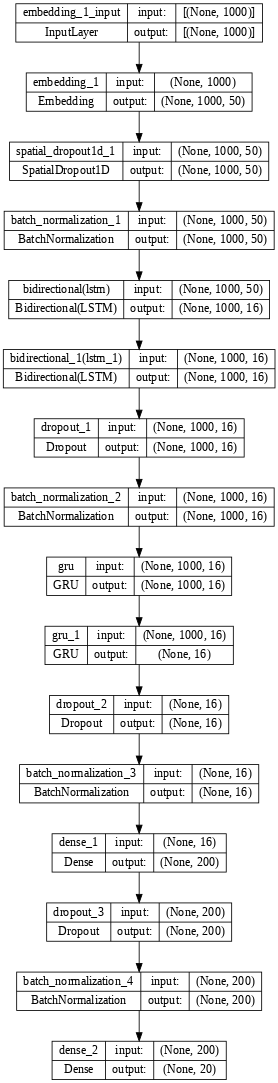

Epoch 1/100
135/135 [==============================] - 47s 266ms/step - loss: 3.1905 - accuracy: 0.0861 - val_loss: 2.9039 - val_accuracy: 0.1242
Epoch 2/100
135/135 [==============================] - 34s 253ms/step - loss: 2.7441 - accuracy: 0.1517 - val_loss: 2.9085 - val_accuracy: 0.1448
Epoch 3/100
135/135 [==============================] - 33s 247ms/step - loss: 2.4635 - accuracy: 0.2071 - val_loss: 3.0516 - val_accuracy: 0.1791
Epoch 4/100
135/135 [==============================] - 38s 278ms/step - loss: 2.0889 - accuracy: 0.3125 - val_loss: 2.1012 - val_accuracy: 0.3479
Epoch 5/100
135/135 [==============================] - 34s 253ms/step - loss: 1.5930 - accuracy: 0.4456 - val_loss: 1.8960 - val_accuracy: 0.3843
Epoch 6/100
135/135 [==============================] - 36s 268ms/step - loss: 0.9451 - accuracy: 0.6646 - val_loss: 3.0616 - val_accuracy: 0.2600
Epoch 7/100
135/135 [==============================] - 34s 254ms/step - loss: 0.4741 - accuracy: 0.8396 - val_loss: 1.2208 -

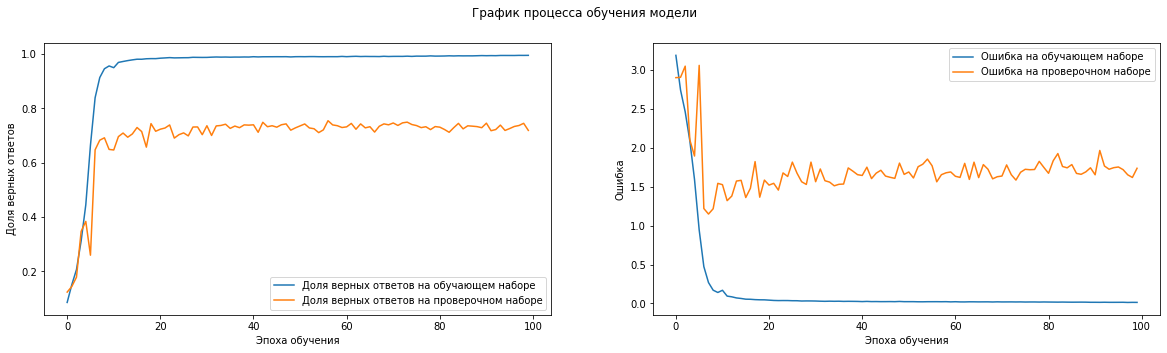

539/539 [==============================] - 44s 78ms/step


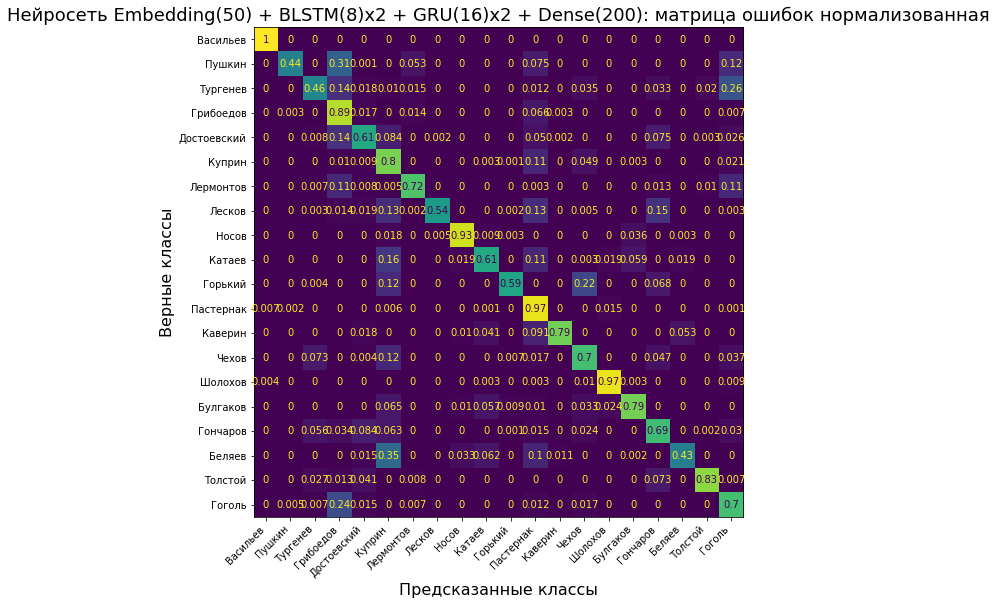

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Васильев             100% сеть отнесла к классу Васильев             - ВЕРНО :-)
Класс: Пушкин                44% сеть отнесла к классу Пушкин               - ВЕРНО :-)
Класс: Тургенев              46% сеть отнесла к классу Тургенев             - ВЕРНО :-)
Класс: Грибоедов             89% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Класс: Достоевский           61% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Куприн                80% сеть отнесла к классу Куприн               - ВЕРНО :-)
Класс: Лермонтов             72% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Лесков                54% сеть отнесла к классу Лесков               - ВЕРНО :-)
Класс: Носов                 93% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Катаев                61% сеть отнесл

In [20]:
model_LSTM_1 = Sequential()
model_LSTM_1.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_1.add(SpatialDropout1D(0.4))
model_LSTM_1.add(BatchNormalization())
# Два двунаправленных рекуррентных слоя LSTM
model_LSTM_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(BatchNormalization())
# Два рекуррентных слоя GRU
model_LSTM_1.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_1.add(GRU(16, reset_after=True))
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(BatchNormalization())
# Дополнительный полносвязный слой
model_LSTM_1.add(Dense(200, activation='relu'))
model_LSTM_1.add(Dropout(0.3))
model_LSTM_1.add(BatchNormalization())
model_LSTM_1.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

Для проверки добавил еще одну модель, с наилучшей точностью:
**Embedding(50) + BLSTM(8)x2 + Dropout(0.4, 0.3)**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 50)          1000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 1000, 50)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_5 (Batc  (None, 1000, 50)         200       
 hNormalization)                                                 
                                                                 
 bidirectional_2 (Bidirectio  (None, 1000, 16)         3776      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 16)               1600      
 nal)                                                 

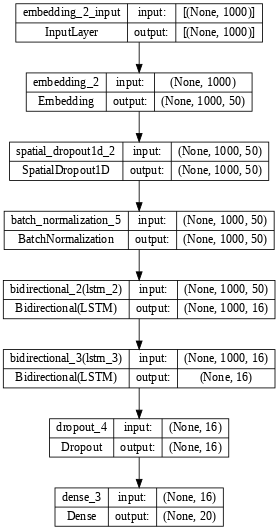

Epoch 1/100
135/135 [==============================] - 30s 179ms/step - loss: 2.8746 - accuracy: 0.1239 - val_loss: 2.9991 - val_accuracy: 0.1580
Epoch 2/100
135/135 [==============================] - 23s 170ms/step - loss: 2.5467 - accuracy: 0.2275 - val_loss: 2.8859 - val_accuracy: 0.1288
Epoch 3/100
135/135 [==============================] - 23s 170ms/step - loss: 2.3715 - accuracy: 0.2630 - val_loss: 2.6461 - val_accuracy: 0.2323
Epoch 4/100
135/135 [==============================] - 23s 169ms/step - loss: 2.2116 - accuracy: 0.2989 - val_loss: 2.4379 - val_accuracy: 0.2687
Epoch 5/100
135/135 [==============================] - 23s 169ms/step - loss: 2.0842 - accuracy: 0.3302 - val_loss: 2.1918 - val_accuracy: 0.3155
Epoch 6/100
135/135 [==============================] - 23s 170ms/step - loss: 1.9296 - accuracy: 0.3692 - val_loss: 2.1133 - val_accuracy: 0.3339
Epoch 7/100
135/135 [==============================] - 23s 173ms/step - loss: 1.8980 - accuracy: 0.3773 - val_loss: 2.1625 -

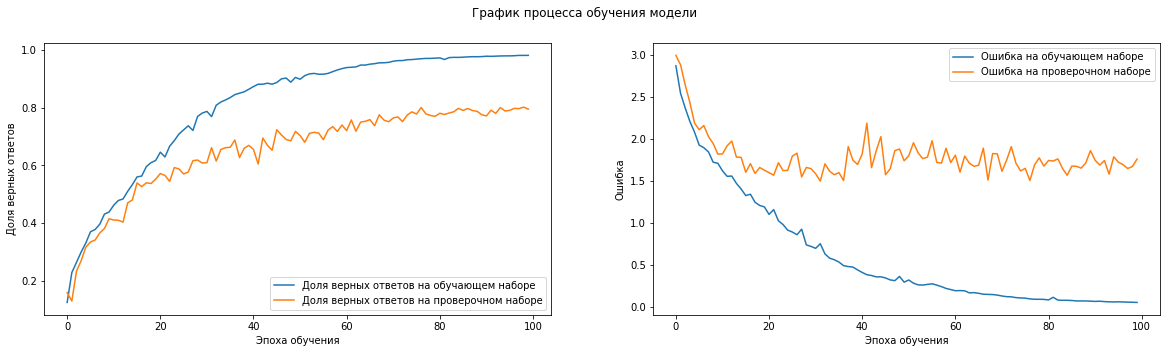

539/539 [==============================] - 31s 55ms/step


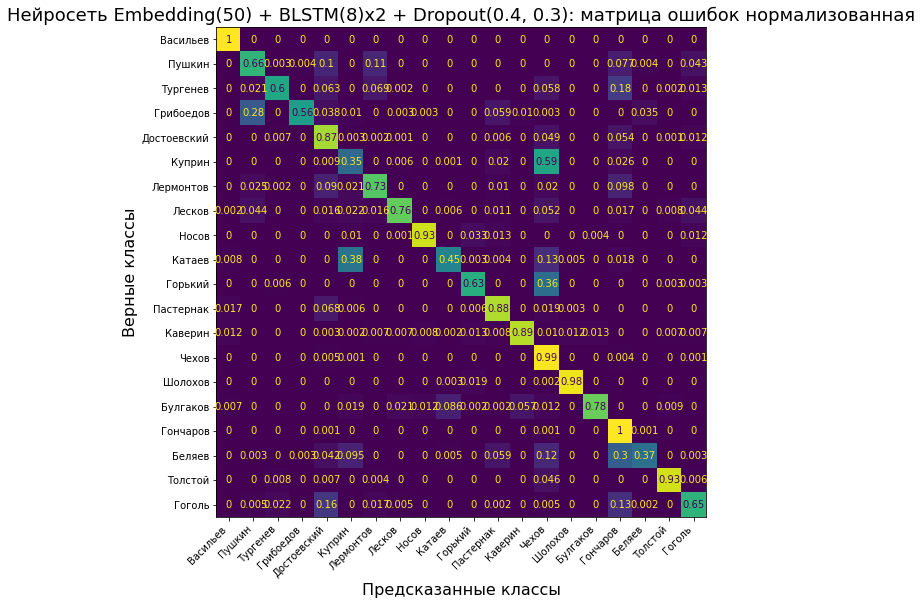

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + Dropout(0.4, 0.3)
Класс: Васильев             100% сеть отнесла к классу Васильев             - ВЕРНО :-)
Класс: Пушкин                66% сеть отнесла к классу Пушкин               - ВЕРНО :-)
Класс: Тургенев              60% сеть отнесла к классу Тургенев             - ВЕРНО :-)
Класс: Грибоедов             56% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Класс: Достоевский           87% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Куприн                59% сеть отнесла к классу Чехов                - НЕВЕРНО :-(
Класс: Лермонтов             74% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Лесков                76% сеть отнесла к классу Лесков               - ВЕРНО :-)
Класс: Носов                 93% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Катаев                45% сеть отнесла к

In [36]:
model_LSTM_2 = Sequential()
model_LSTM_2.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_2.add(SpatialDropout1D(0.4))
model_LSTM_2.add(BatchNormalization())
# Два двунаправленных рекуррентных слоя LSTM
model_LSTM_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_2.add(Bidirectional(LSTM(8)))
model_LSTM_2.add(Dropout(0.3))
model_LSTM_2.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_LSTM_2,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + Dropout(0.4, 0.3)')

In [25]:
# Текст сочинения для теста

essay_text = '''
У войны не женское лицо 
Война всегда была большим горем для народа. Трудно представить, какие страшные жертвы и потери оставляет за собой это асоциальное явление. Враг был в полном смысле слова бесчеловечен. Следуя по принципам веры в существование высшей арийской расы, было уничтожено несметное количество людей. Сколько людей было угнано в рабство, сколько сгинуло в концлагерях, сколько деревень было сожжено в то время… Масштабы разрушений и человеческих жертв шокируют и вряд ли кого смогут оставить равнодушным. Казалось, что воевать - мужское дело. Но нет! На оборону Родины встали и женщины, которые наравне с мужчинами переносили все тяготы военного времени. Их вклад в приближение Великой победы неоценим. Писатель Борис Васильев в своей повести «А зори здесь тихие…» описывает жизнь и гибель пяти девушек-зенитчиц. Пришедшие на войну по собственной воле, почти не умевшие стрелять, они погибают от рук фашистской разведки, защищая себя и Родину. Женщины и девушки, совсем юные и молодые, война не ставит границ возраста и пола, здесь все и каждый - солдат. В тылу были немцы, и каждый солдат чувствовал свой долг перед Родиной, Остановить и уничтожить врага любой ценой. И они остановят его, но ценой своей жизни. Повествование ведется от имени коменданта разъезда Васкова. Вся повесть построена на его воспоминаниях. В рамках послевоенного времени идет повествование о прошедших ужасах бесчеловечной войны. И это играет важную роль в идейно-художественном восприятии повести. Эта повесть написана человеком, побывавшим и прошедшим всю войну, поэтому вся она написана правдоподобно и захватывающе, с ярким выделением всех ужасов войны. Свою повесть автор посвящает нравственной проблеме формирования и преобразования характера и психики личности в условиях войны. Наболевшая тема войны, несправедливой и жестокой, поведение разных людей в ее условиях показано на примере героев повести. У каждого из них свое отношение к войне, свои мотивы борьбы с фашистами, кроме основных, и все они разные люди. И именно этим солдатам, молодым девчонкам, предстоит проявить себя в условиях войны; кому-то впервые, а кому-то и нет. Не все девушки проявляют героизм и мужество, не все остаются твердыми и стойкими после первого боя, но все девушки погибают. Только старшина Васков остается в живых и доводит выполнение приказа до конца. Каждый персонаж Васильева имеет свой колорит и свою гамму чувств. Происходящие события заставляют сопереживать каждому герою. После прочтения повести и просмотра экранизации имеет место чувство боли и жалости к юным зенитчицам, павшим смертью храбрых во имя освобождения Родины. Никто не мог знать, что, получив задание пойти и захватить в плен двух немецких разведчиков, маленький отряд из шести человек наткнется на шестнадцать фашистских солдат. Силы несравнимы, но ни старшине, ни пятерым девушкам даже в голову не приходит отступить, Они не выбирают. Всем пяти юным зенитчицам суждено погибнуть в этом лесу. И не всех настигнет героическая смерть. Но в повести все мерится одинаковой мерой. Как говорили в войну, жизнь одна и смерть одна. И всех девушек одинаково можно назвать подлинными героинями войны. На первый взгляд, что может быть общего у ответственной, строгой Риты Осяниной, неуверенной в себе фантазерки Гали Четвертак, метательной Сони Гурвич, молчаливой Лизы Бричкиной и озорной дерзкой красавицы Женьки Комельковой? Но, как ни странно, между ними не возникает даже тени непонимания. Это объясняется в немалой степени тем, что их сблизили исключительные обстоятельства. Недаром потом Федот Евграфыч назовет себя братом девушек, недаром возьмет на себя заботу о сыне погибшей Риты Осяниной. Есть еще в этих шестерых, несмотря на разность возрастов, воспитания, образования, единство отношения к жизни, людям, войне, преданность Родине и готовность отдать за нее жизнь. Им шестерым нужно, во что бы то ни стало держать свои позиции, словно именно за ними "вся Россия сошлась". И они держат. Рассмотрим каждый персонаж в отдельности. Начнем с коменданта Васкова Федота Ефграфовича. Под этим персонажем зашифрован одинокий человек. Для него в жизни кроме уставов, положений, приказов начальства и вверенного ему отделения больше ничего не осталось. Все война отняла. Поэтому всего себя он без остатка отдавал службе Родине. Он жил строго по уставу, как предписано, и навязывал этот устав всем, кто его окружал. В подчинение ему назначали много взводов, и постоянно он просил у начальства прислать ему других. Взводы состояли из молодых ребят, которые не брезговали спиртным и прогулками с молодыми особами. Все это невероятно раздражало Васкова и постоянно подталкивало на очередную просьбу о замене. Разумеется, такие просьбы раздражали и само начальство. Начальство и в очередной раз не проигнорировало просьбу Васкова. И правда: присланные зенитчики не употребляли спиртное. Про прогулки с дамами тоже можно было забыть, потому как сами зенитчики - девушки! «Прислали, значит, непьющих…» - так отреагировал старшина на прибытие новичков. Его можно понять, человек привык к юношам, у которых ветер в голове и совершенно не те мысли, даже несмотря на то, что идет война. А тут перед ним предстала толпа юных девиц, которые и оружие-то толком в руках не держали. И вот они, еще необстрелянные молодые красавицы попадают к Васкову в распоряжение. Помимо приятной внешности вновь прибывшие были к тому же остры на язык. Без остроумных замечаний и подколок в адрес старшины не обходилось. Все это унижало Васкова. Но сами девушки были решительными и, кроме того, хозяйственными. В жизни коменданта все поменялось. Мог ли он ожидать такого? И мог ли он знать, что эти вот девчата-неумехи станут ему впоследствии почти как родными? Но все это позже, а пока - война, и тут нельзя забывать, что даже эти девушки - солдаты. И у них такой же долг, как и у Васкова. Несмотря на заметную грубоватость, Васков проявляет заботу обо всех пяти зенитчицах, которых он выбрал для поимки двух, как казалось тогда, немецких диверсантов. Образ Васкова на протяжении повести испытывает перерождение. Но не только сам старшина является тому причиной. Немалую долю внесли и девушки, каждая по-своему. Между тем мимо Васкова и юной «дикарки» Лизы Бричкиной пробегает искра симпатии. Васков оказывает ей доверие, зная, что она все время прожила на кордоне в лесу, а потому каждую лесную мелочь знала и примечала все, что к этим мелочам не относилось. Все были удивлены, когда Лиза на вопрос «Ничего странного не заметили?» ответила: «С кустов роса сбита», все были ошеломлены, особенно Васков. Федот Ефграфович тяжело переживает гибель девушек. Он душевно привязался к каждой из них, каждая из смертей оставила шрам на его сердце. Все эти шрамы разожгли страшную ненависть в сердце старшины. Жажда мести управляла сознанием Васкова после смерти Риты Осяниной, которая попросила забрать к себе ее маленького сына. Васков впоследствии заменит ему отца. Немцы также понесли потери и заметно ослабли. Однако все равно Васков был против них один. Невредимым осталось командование диверсантов. Преисполненный злостью и желанием отомстить за юных зенитчиц, он врывается в скит (там немцы устроили штаб) и берет в плен всех, кто в нем находился. Возможно, они не знали русского языка, но они наверняка понимали все, что выложил им Васков. Он вселил в них страх перед видом русского солдата, которого они лишили очень дорогих ему людей. Стало ясно, что они теперь бессильны, и им ничего не оставалось, кроме как подчиниться воле Васкова, сумевшего взять над ними верх. И только тогда Васков позволил себе «расслабиться», когда увидел за своей спиной зовущих его девушек, спешивших к нему на помощь. У Васкова была прострелена рука, но у него в разы сильнее болело сердце. Он чувствовал себя виноватым в смерти каждой из девушек. Смерти некоторых можно было и не допустить, если проанализировать обстоятельства каждой из них. Не потеряв кисета, он, возможно, избежал бы смерти Сони Гурвич; не отправляя натощак Лизу Бричкину, и убедительнее заставив ее, как следует передохнуть на островке в болоте, тоже можно было бы избежать ее гибели. Но разве можно было знать все это наперед? Никого уже не вернешь. А последняя просьба Риты Осяниной, последней из пяти зенитчиц, стала настоящим приказом, ослушаться которого Васков просто не посмел. В повести присутствует момент, когда Васков, лишенный той самой простреленной руки, вместе с сыном покойной Риты возлагает цветы на памятную доску с именами всех пяти девушек-зенитчиц. И воспитал он его как своего, испытывая чувство выполненного долга перед погибшей во имя Родины, Маргариты Осяниной. Сложна история Бричкиной Елизаветы, которая приняла нелепую, но ужасную и мучительную смерть. Лиза - молчаливая, несколько замкнутая в себе девушка. Она жила вместе с родителями на кордоне в лесу. Преисполненная чувством надежды на счастье и ожиданием светлого будущего она шла по жизни. Она всегда вспоминала напутствия родителей и обещания ей «счастливого завтра». Прожив в окружении леса, она выучила и поняла все, что относится к нему. Лиза была хозяйственной и вполне приспособленной к жизни крепкой девахой. Но в то же время она была очень ранима и сентиментальна. До войны Лиза влюбилась только один раз. Но чувства оказались невзаимными. Лиза переживала, но, будучи сильной духом, она снесла эту боль, понимая своим юным умом, что это не последняя боль и что жизнь подкинет испытание похуже, а в конце непременно наступит то самое «завтра», о котором Лиза грезила всю свою жизнь. Попав в отряд зенитчиц, Лиза была спокойной и сдержанной. Ее трудно было назвать душой компании, как, например, Кирьянову, которая до смерти любила сплетни и шутки над Васковым. Лиза не была сплетницей, и поэтому не принимала участие в подобных разговорах. Помимо всего этого ей понравился Васков. И она не могла не возразить Кирьяновой, когда та стала при всех распускать сплетни про коменданта. В ответ она услышала только насмешки. Лиза не выдержала и со слезами поспешила удалиться. И только Рита как командир отделения сделала замечание Кирьяновой и побежала успокаивать Лизу, дав ей при этом понять, что надо быть проще, и не следует верить подобным кляузам. Когда Осянина заметила двух немецких диверсантов, Васков стал собирать отряд из пяти девушек. Лиза, не раздумывая, попросилась вместе со всеми. Васков согласился. За все время пути Лиза удивляла Васкова, все больше и больше привлекая его внимание. Васков так и говорил ей: «Ты примечай все, Лизавета, ты у нас человек лесной…». Даже тогда, когда весь отряд шел по болоту, Лиза ни разу не оступилась и, кроме того, помогала остальным, если кто-то оступился, провалился или просто не мог вытянуть ногу из вязкого месива. Прибыв на место, все стали устраивать себе позиции для наблюдения. Лиза себе обустроила место грамотно и удобно. Придя к ней, Васков не удержался от похвалы. Собираясь уходить, он напел ей песню: «Лиза, Лиза, Лизавета, что ж не шлешь ты мне привета…». Лиза было хотела сказать, как поют эту песню на ее родине, но Васков мягко оборвал ее: «После споем с тобой, Лизавета. Вот, выполним боевой приказ и споем…». Эти слова вселили в сердце юной Лизы надежду. Она поняла, что теперь-то ее чувства взаимны и долгожданное счастье теперь тоже близко. Осознав всю опасность положения, когда вместо двух диверсантов на горизонте показалось шестнадцать, Васков сразу понял, кого пошлет за подмогой. Дав Бричкиной все указания, он напоследок сказал: «Дуй, Лизавета Батьковна!», шутя, конечно. Лиза очень торопилась. Она хотела как можно скорее привести помощь. Всю дорогу она думала о словах Федота Евграфовича и грела себя мыслью, что они обязательно выполнят приказ и споют. Проходя через болото, Лиза испытывала невероятный страх, как говорит нам автор «животный ужас». И это понятно, ведь тогда, когда она вместе со всеми шла, ей в случае чего обязательно помогли бы, а теперь она одна, в мертвом, глухом болоте, где нет ни одной живой души, которая смогла бы ей помочь. Но слова Васкова и близость «заветного пня», который был ориентиром для Лизы, а значит твердой земли под ногами, разогрели душу Лизы и подняли ее настроение. Но автор решает совершить трагический поворот событий. Увидев внезапно появившийся пузырь, который вспучился почти рядом с ней, Лиза оступается и попадает в самую трясину. Попытки выбраться и истошные крики о помощи оказываются тщетными. И в тот момент, когда наступило последнее мгновение в жизни Лизы, появляется солнце, как обещание счастья и символ надежды. Всем известна поговорка: надежда умирает последней. Так и случилось с Лизой. Все ее надежды исчезли вместе с ней в мерзостных глубинах болота. Автор пишет: «…Осталась от нее только юбка, которую она привязала к краю своей слеги*, и больше ничего, даже надежды, что помощь придет». Обратимся к экранизации повести. Вообще фильм отражает как события войны, так и мирное время, причем война снята в черно-белых тонах, мирное же время - в цветных. Одним из таких «цветных» фрагментов является момент в подсознании Васкова, когда он сидел на островке среди непролазной топи и размышлял о бессмысленной кончине Лизы, на которую он возлагал огромные надежды, прежде всего на скорейшее прибытие подмоги. Перед нами картина: на белом фоне появляется Лиза, а где-то за кадром Васков. Он спрашивает ее: нравственный характер девушка война Как же ты так, Лизавета?.. Не по своей воле, но Лиза подвела своих товарищей. Однако автор не осуждает ее, напротив - он сочувствует ей. Просматривая фильм, можно отметить, что образ Лизы в повести слегка не соответствует образу из фильма. В повести Лиза - мечтательная и спокойная, но, в то же время серьезная девушка. Елена Драпеко, сыгравшая роль Бричкиной, несколько не подгадала образ именно «сентиментальной и мечтательной Лизы», остальные же ее качества актриса передала целиком и полностью. Даже сцену гибели Елена Драпеко сыграла без дублера. Было снято пять дублей. Динамитом была взорвана и помечена воронка, в которую должна была погружаться актриса. Сцена снималась в ноябре, в холодной грязи, но те чувства, что испытывала Лиза, когда ее засасывало все глубже в трясину, были переданы полностью, актриса сама подтверждает, что ей во время съемок было по-настоящему страшно. Ненужной была смерть Сони Гурвич, которая стремясь сделать доброе дело, погибает от вражеского клинка. Студентка, готовившаяся к летней сессии, вынуждена сражаться с немецкими оккупантами. Она и ее родители были еврейской нации, а политика геноцида предполагала уничтожить, прежде всего, евреев. Нетрудно понять, почему оказалась Соня в зенитном отряде. В ту группу, которую набрал Васков, Соня попала потому, что знала немецкий язык и могла изъясняться. Как и Бричкина, Соня была тихоней. Кроме того она очень любила стихи и часто их читала вслух, либо самой себе, либо своим товарищам. Васков для ясности дела называл ее переводчицей и старался уберечь от опасности. Перед «форсированием» болота он приказал Бричкиной взять ее вещмешок и сказал ей идти за ним, потом только всем остальным. Васков обронил свой памятный кисет с табаком. Соня поняла его переживания по поводу потери и решила помочь ему. Вспомнив, где она видела этот кисет, Соня метнулась на его поиски. Васков шепотом приказал ей вернуться, но Соня уже не слышала его. Схвативший ее немецкий солдат вонзил ей в грудь нож. Не ожидав того, что передним окажется девушка, он сделал два удара ножом, потому как первый из них не попал сразу в сердце. Поэтому Соня успела вскрикнуть. Решив сделать доброе дело своему начальнику, Соня Гурвич ушла из жизни. Гибель Сони была первой потерей отряда. Именно поэтому все, особенно Васков восприняли ее очень серьезно. Васков винил себя в ее смерти, рассуждая о том, как могла бы жить Соня, если бы послушалась его и осталась на месте. Но ничего сделать уже нельзя было. Ее похоронили, а Васков снял с ее кителя петлицы. Такие же петлицы он снимет в последствие со всех кителей погибших девушек. Следующие три персонажа можно рассмотреть одновременно. Это образы Риты Осяниной (девичья фамилия Муштакова), Жени Комельковой и Гали Четвертак. Три эти девушки всегда держались вместе. Юная оторва Женя была невероятно хороша собой. Веселая «хохотушка» имела тяжелую историю жизни. На ее глазах была убита вся семья, погиб любимый человек, поэтому у нее были свои личные счеты с немцами. Она вместе с Соней попали в распоряжение к Васкову несколько позже остальных, но тем не менее они сразу влились в коллектив. С Ритой у нее тоже не сразу вышла дружба, но после душевной беседы обе девушки увидели в себе хороших подруг. Невзрачную Галю они тоже приняли к себе в «компанию» не сразу. Галя показала себя как хороший человек, который не предаст и последний кусок хлеба отдаст товарищу. Сумев сохранить тайну Риты, Галя стала одной из них. Юная Галя жила в детском доме. На фронт она попала обманом. Но желая оказать помощь Красной армии, она смело пошла на обман, соврав про свой возраст. Галя была очень робкой. С раннего детства лишенная материнского тепла и заботы, она придумывала себе истории про свою мать, веря, что она не сирота, что ее мать вернется и заберет ее. Все смеялись с этих историй, а несчастная Галя проглатывала в себя боль и старалась придумать другие истории, чтобы позабавить других. Проходя через болото, Галя «утопила» свой сапог, не успев дойти до берега. Васков сделал ей «чуню», перевязав еловые ветки вокруг ноги веревками. Однако Галя все равно простудилась. Васков укрыл ее своим картузом и дал выпить спирта, в надежде, что Гале к утру полегчает. После смерти Сони Васков приказывает надеть ее сапоги. Галя тут же запротивилась, начав придумывать очередную историю про несуществующую мать, которая работает врачом и запрещает снимать с мертвого человека обувь. Рита жестоко оборвала ее, сказав всем, что она подкидыш, и матери в помине нет. Женя заступилась за Галю. Во время войны очень важно держаться всем вместе и не ссориться. Необходимо стоять друг за друга и дорожить каждым, потому как одного из них завтра уже может и не быть. Женя так и говорит: «Нам сейчас без злобы надо, а то остервенеем, как немцы…». Смерть Гали можно назвать глупой. Поддавшись испугу, она срывается с места и с криком бежит. Немецкая пуля моментально ее настигает и Галя гибнет. Рита Осянина за свои девятнадцать лет успела побывать замужем и родить сына. Этим самым она вызывала страшную зависть со стороны своих «сослуживок». Ее муж погиб в первые дни войны. Рита сама ушла в зенитчицы, желая отомстить за смерть мужа. Попав нам разъезд, Рита по ночам стала убегать в город к сыну и больной матери, возвращаясь под утро. Однажды таким же утром Рита и наткнулась на тех двух злосчастных диверсантов, принесшим всему отделению столько бед и потерь. Оставшись втроем с Васковым и Женей, нужно было всеми возможными путями остановить врага, не дать ему добраться до Кировской железной дороги. Помощи ждать было бесполезно, боеприпасы были на исходе. В этот момент и проявляется героизм оставшихся девушек и старшины Васкова. Рита получила ранение и постепенно теряла кровь. Женя с последними патронами стала уводить немцев от раненной подруги, дав время Васкову помочь Рите. Женя приняла героическую смерть. Она не боялась умереть. Последние патроны иссякли, однако Женя не потеряла чувства собственного достоинства и умерла с высоко поднятой головой, не сдавшись врагу. Ее последние слова означали, что убив одного солдата, пусть даже девушку, вы не перебьете весь Советский союз. Женя буквально выругалась перед смертью, выложив все то, что у нее наболело. Не весь немецкий отряд был повержен. Рита и Васков прекрасно знали об этом. Рита чувствовала, что теряет много крови и что силы на исходе просит Васкова принять к себе ее сына и приглядеть за мамой. Тогда же она и признается в своих ночных побегах из расположения. Какая теперь разница? Рита ясно понимала, что смерть неизбежна, поэтому и открылась Васкову. Рита могла и выжить, но почему же она решила покончить с собой? Васков остался один. Рита ранена, более того она не могла идти. Васков в одиночку мог совершенно спокойно выбраться и привести подмогу. Но он ни за что не оставил бы раненого бойца. А вместе с Ритой он станет доступной мишенью. Рита не хотела быть обузой для него и решает покончить с собой, стремясь помочь этим своему старшине. Смерть Риты Осяниной психологически самый сложный момент повести. Б. Васильев очень точно передает состояние молодой двадцатилетней девушки, прекрасно осознающей, что рана ее смертельна и что, кроме мучений, её ничего не ждет. Но при этом её заботила только одна мысль: она думала о маленьком сыне, понимая, что ее робкая, болезненная мать вряд ли сможет вырастить внука. Сила Федота Васкова в том, что он умеет найти в нужный момент самые точные слова, поэтому ему можно верить. И когда он говорит: «Не тревожься, Рита, понял я все», становится ясно, что он действительно никогда не бросит маленького Алика Осянина, а скорей всего усыновит его и воспитает честным человеком. Описание смерти Риты Осяниной в повести занимает всего несколько строк. Вначале тихо прозвучал выстрел. «Рита выстрелила в висок, и крови почти не было. Синие порошинки густо окаймили пулевое отверстие, и Васков почему-то особенно долго смотрел на них. Потом отнес Риту в сторону и начал рыть яму в том месте, где она до этого лежала». Подтекст, свойственный авторской манере Б. Васильева, позволяет прочесть между строк, что слово свое Васков сдержал, он усыновил Ритиного сына, который стал капитаном-ракетчиком, что все эти годы Васков помнил о погибших девушках и что самое главное - уважение современных молодых людей к военному прошлому. Неизвестный молодой человек хотел помочь донести мраморную плиту до могилы, но не решился. Испугался задеть чьи-то святые чувства. И пока на земле люди будут испытывать подобное уважение к павшим, не будет войны - вот он, основной смысл новости «А зори здесь тихие...» Казалось бы, как все просто и буднично и как становится жутко от этой будничности. Такие красивые, молодые, абсолютно здоровые девушки уходят в небытие. Вот в чем ужас войны! Вот почему ей не должно быть места на земле. Кроме того, Б. Васильев подчёркивает, что за смерть этих девушек кому-то нужно ответить, возможно, потом, в будущем. Об этом просто и доходчиво говорит старшина Васков: «Пока война - понятно. А потом, когда мир будет? Будет понятно, почему вам умирать приходилось? Почему я фрицев этих дальше не пустил, почему такое решение принял? Что ответить, когда спросят: что ж это вы, мужики, мам наших от пуль защитить не могли? Что ж это вы со смертью их оженили, а сами - целенькие?» Ведь кто-то должен будет ответить на эти вопросы. Но кто? Возможно, все мы. Трагизм и нелепость происходящего подчеркивает сказочная красота Легонтова скита, расположенного рядом с озером. И здесь, среди смерти и крови, «тишина могильная стояла, аж звон в ушах». Итак, война - явление противоестественное. Вдвойне же страшной становится война, когда погибают женщины, потому что именно тогда, по мнению Б. Васильева, «обрывается ниточка, ведущая в будущее». Но будущее, к счастью, оказывается не только «вечным», но и благодарным. Не случайно в эпилоге приехавший отдохнуть на Легонтово озеро студент написал в письме другу: «Здесь, оказывается, воевали, старик. Воевали, когда нас еще не было на свете... Мы разыскали могилу - она за речкой, в лесу... А зори-то здесь тихие, только сегодня разглядел. И чистые-чистые, как слезы...» В повести Б. Васильева мир торжествует. 
Подвиг девушек не забыт, память о них будет вечным напоминанием о том, что «у войны - не женское лицо».
'''

In [31]:
seq_essay = tokenizer.texts_to_sequences([essay_text])
x_essay, _ = vectorize_sequence(seq_essay, WIN_SIZE, WIN_HOP)

In [32]:
# Выведем размер проверочной выборки
print(x_essay.shape)

(27, 1000)


In [33]:
y_pred = model_LSTM_1.predict(x_essay)

1/1 [==============================] - 0s 124ms/step


In [34]:
# Разберем результаты предсказания

r = np.argmax(y_pred, axis=1)                     # Найдем индексы писателей
unique, counts = np.unique(r, return_counts=True) # Найдем полученые индексы и их количество
counts = counts/y_pred.shape[0]*100               # Считаем долю каждного полученного индекса 
print(unique, counts)                             # Выведем полученые индексы и их доли

[ 0 11] [74.07407407 25.92592593]


In [35]:
# Выведем результат предсказания первой модели

for i in range(len(unique)):
  print('{:10s} - {:<.2f}%'.format(CLASS_LIST[unique[i]],counts[i]))

Васильев   - 74.07%
Пастернак  - 25.93%


In [37]:
y_pred = model_LSTM_2.predict(x_essay)

1/1 [==============================] - 0s 85ms/step


In [38]:
# Разберем результаты предсказания

r = np.argmax(y_pred, axis=1)                     # Найдем индексы писателей
unique, counts = np.unique(r, return_counts=True) # Найдем полученые индексы и их количество
counts = counts/y_pred.shape[0]*100               # Считаем долю каждного полученного индекса 
print(unique, counts)                             # Выведем полученые индексы и их доли

[ 0 11 12] [77.77777778  3.7037037  18.51851852]


In [39]:
# Выведем результат предсказания первой модели

for i in range(len(unique)):
  print('{:10s} - {:<.2f}%'.format(CLASS_LIST[unique[i]],counts[i]))

Васильев   - 77.78%
Пастернак  - 3.70%
Каверин    - 18.52%


**Результат**: судя по решению двух обученных нейросетей, данное сочинение написал Васильев.